# Using Python for neuroimaging

The primary goal of this workshop is to become familiar with loading, modifying, saving, and visualizing neuroimages in Python. A secondary goal is to develop a conceptual understanding of the data structures involved, to facilitate diagnosing problems in data or analysis pipelines.

To these ends, we'll be exploring two libraries: [nibabel](http://nipy.org/nibabel/) and [nilearn](https://nilearn.github.io/).

Each of these projects has excellent documentation. While this should get you started, it is well worth your time to look through these sites.

## Setup

In [19]:
import sys
import os
import numpy as np
import nibabel as nib
import nilearn as nl

# Image settings
import nilearn.plotting
import matplotlib as mpl
import pylab as plt
import seaborn as sns
sns.set_style('white')
%matplotlib inline
mpl.rcParams['font.family'] = 'DejaVu Sans'

out_dir = '/tmp'

Just to confirm we're all on the same page, your versions should be the same as mine:

In [2]:
print("Python version:", sys.version.split()[0])
print("nibabel version: {} (Commit: {})".format(nib.__version__, open(os.path.join(os.path.dirname(nib.__file__), 'COMMIT_INFO.txt')).readlines()[1].split()[2]))
print("nilearn version:", nilearn.__version__)

Python version: 3.5.4
nibabel version: 2.1.0 (Commit: $Format:%h$)
nilearn version: 0.3.1


# Nibabel

Nibabel is a low-level Python library that gives access to a variety of imaging formats, with a particular focus on providing a common interface to the various volumetric formats produced by scanners and used in common neuroimaging toolkits.

 - NIfTI-1
 - NIfTI-2
 - SPM Analyze
 - FreeSurfer .mgh/.mgz files
 - Philips PAR/REC
 - Siemens ECAT
 - DICOM (limited support)

It also supports surface file formats

 - GIFTI
 - FreeSurfer surfaces, labels and annotations

Connectivity

 - CIFTI-2 (next release!)

Tractocgraphy

 - TrackViz .trk files

And a number of related formats.

*Almost* all of these can be loaded through the `nibabel.load` interface.

## Loading and inspecting images in nibabel

In [5]:
t1 = nib.load('/data/ds000114/sub-01/ses-test/anat/sub-01_ses-test_T1w.nii.gz')
print(t1)

<class 'nibabel.nifti1.Nifti1Image'>
data shape (256, 156, 256)
affine: 
[[  9.99131918e-01  -5.16291820e-02   1.25127016e-02  -1.25263863e+02]
 [  4.07721959e-02   1.29202044e+00  -9.81179178e-02  -7.31330109e+01]
 [ -8.54506902e-03   1.28044292e-01   9.95096147e-01  -1.77554291e+02]
 [  0.00000000e+00   0.00000000e+00   0.00000000e+00   1.00000000e+00]]
metadata:
<class 'nibabel.nifti1.Nifti1Header'> object, endian='<'
sizeof_hdr      : 348
data_type       : b''
db_name         : b''
extents         : 0
session_error   : 0
regular         : b'r'
dim_info        : 0
dim             : [  3 256 156 256   1   1   1   1]
intent_p1       : 0.0
intent_p2       : 0.0
intent_p3       : 0.0
intent_code     : none
datatype        : float32
bitpix          : 32
slice_start     : 0
pixdim          : [ 1.          1.          1.29937589  1.          0.009668    0.          0.
  0.        ]
vox_offset      : 0.0
scl_slope       : nan
scl_inter       : nan
slice_end       : 0
slice_code      : unkno

This data-affine-header structure is common to volumetric formats in nibabel, though the details of the header will vary from format to format.

These objects can be accessed through the following interfaces.

In [6]:
data = t1.get_data()
affine = t1.affine
header = t1.header

###### Aside
Why not just `t1.data`? Working with neuroimages can use a lot of memory, so nibabel works hard to be memory efficient. If it can read some data while leaving the rest on disk, it will. `t1.get_data()` reflects that it's doing some work behind the scenes.

### Data

The data is a simple numpy array. It has a shape, it can be sliced and generally manipulated as you would any array.

(256, 156, 256)


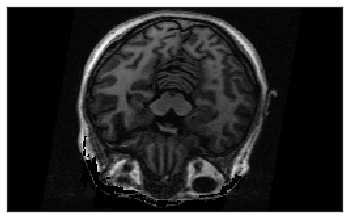

In [7]:
print(data.shape)
fig = plt.imshow(data[:,:,data.shape[2] // 2].T, cmap='Greys_r')
fig.axes.set_xticks([])
_ = fig.axes.set_yticks([])

Nibabel has its own viewer, which can be accessed through `img.orthoview()`. This viewer scales voxels to reflect their size, and labels orientations. From a normal IPython console, it will create an interactive window, and you can click to select different slices, similar to `mricron`.

<OrthoSlicer3D: /data/ds000114/sub-01/ses-test/anat/sub-01_ses-test_T1w.nii.gz (256, 156, 256)>

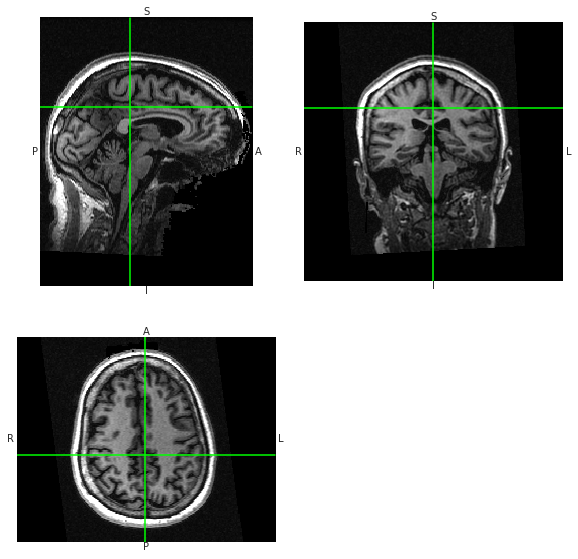

In [8]:
t1.orthoview()

###### Quirk

 - `img.get_data_dtype()` shows the type of the data on disk
 - `img.get_data().dtype` shows the type of the data that you're working with

These are not always the same, and not being clear on this [has caused problems](https://github.com/nipy/nibabel/issues/490). Further, modifying one does not update the other. This is especially important to keep in mind later, when saving files.

In [9]:
print((data.dtype, t1.get_data_dtype()))

(dtype('<f4'), dtype('<f4'))


###### Warning

`img.orthoview()` may not work properly on OS X.

### Affine

The affine is a 4 x 4 numpy array. This describes the transformation from the voxel space (indices [i, j, k]) to the reference space (distance in mm (x, y, z)).

It can be used, for instance, to discover the voxel that contains the origin of the image:

In [10]:
x, y, z, _ = np.linalg.pinv(affine).dot(np.array([0, 0, 0, 1])).astype(int)

print("Affine:")
print(affine)
print
print("Center: ({:d}, {:d}, {:d})".format(x, y, z))

Affine:
[[  9.99131918e-01  -5.16291820e-02   1.25127016e-02  -1.25263863e+02]
 [  4.07721959e-02   1.29202044e+00  -9.81179178e-02  -7.31330109e+01]
 [ -8.54506902e-03   1.28044292e-01   9.95096147e-01  -1.77554291e+02]
 [  0.00000000e+00   0.00000000e+00   0.00000000e+00   1.00000000e+00]]
Center: (126, 65, 171)


The affine also encodes the axis orientation and voxel sizes:

In [11]:
nib.aff2axcodes(affine)

('R', 'A', 'S')

In [12]:
nib.affines.voxel_sizes(affine)

array([ 0.99999999,  1.2993759 ,  1.00000002])

### Header

The header is a nibabel structure that stores all of the metadata of the image. You can query it directly, if necessary:

In [13]:
print(header)
print
header.structarr['descrip']

<class 'nibabel.nifti1.Nifti1Header'> object, endian='<'
sizeof_hdr      : 348
data_type       : b''
db_name         : b''
extents         : 0
session_error   : 0
regular         : b'r'
dim_info        : 0
dim             : [  3 256 156 256   1   1   1   1]
intent_p1       : 0.0
intent_p2       : 0.0
intent_p3       : 0.0
intent_code     : none
datatype        : float32
bitpix          : 32
slice_start     : 0
pixdim          : [ 1.          1.          1.29937589  1.          0.009668    0.          0.
  0.        ]
vox_offset      : 0.0
scl_slope       : nan
scl_inter       : nan
slice_end       : 0
slice_code      : unknown
xyzt_units      : 10
cal_max         : 0.0
cal_min         : 0.0
slice_duration  : 0.0
toffset         : 0.0
glmax           : 0
glmin           : 0
descrip         : b'FSL5.0'
aux_file        : b''
qform_code      : scanner
sform_code      : scanner
quatern_b       : 0.04923562332987785
quatern_c       : 0.0052719819359481335
quatern_d       : 0.0201553311198949

array(b'FSL5.0',
      dtype='|S80')

But it also provides interfaces for the more common information.

In [14]:
for method in ('get_zooms', 'get_xyzt_units', 'get_qform', 'get_sform'):
    print("header.{}()".format(method))
    print(getattr(header, method)())
    print

header.get_zooms()
(1.0, 1.2993759, 1.0)
header.get_xyzt_units()
('mm', 'sec')
header.get_qform()
[[  9.99131938e-01  -5.16292391e-02   1.25136054e-02  -1.25263863e+02]
 [  4.07721521e-02   1.29202043e+00  -9.81179047e-02  -7.31330109e+01]
 [ -8.54416425e-03   1.28044319e-01   9.95096119e-01  -1.77554291e+02]
 [  0.00000000e+00   0.00000000e+00   0.00000000e+00   1.00000000e+00]]
header.get_sform()
[[  9.99131918e-01  -5.16291820e-02   1.25127016e-02  -1.25263863e+02]
 [  4.07721959e-02   1.29202044e+00  -9.81179178e-02  -7.31330109e+01]
 [ -8.54506902e-03   1.28044292e-01   9.95096147e-01  -1.77554291e+02]
 [  0.00000000e+00   0.00000000e+00   0.00000000e+00   1.00000000e+00]]


Normally, we're not particularly interested in the header or the affine. But it's important to know they're there, and, especially, to remember to copy them when making new images, so that derivatives stay aligned with the original image.

## nib-ls

Nibabel comes packaged with a command-line tool to print common metadata about any (volumetric) neuroimaging format nibabel supports. By default, it shows (on-disk) data type, dimensions and voxel sizes. We can also inspect header fields by name, for instance, `descrip`:

In [16]:
!nib-ls -H descrip /data/ds000114/sub-01/ses-test/anat/sub-01_ses-test_T1w.nii.gz

/data/ds000114/sub-01/ses-test/anat/sub-01_ses-test_T1w.nii.gz float32 [256, 156, 256] 1.00x1.30x1.00   b'FSL5.0' sform



## Creating and saving images

Suppose we want to save space by rescaling our image to a smaller datatype, such as an unsigned byte. To do this, we create a new image with a modified data array, and copy over the old affine and header. We then use the `img.to_filename()` method to save.

In [17]:
rescaled = ((data - data.min()) * 255. / (data.max() - data.min())).astype(np.uint8)
rescaled_img = nib.Nifti1Image(rescaled, affine=affine, header=header)

print((rescaled_img.get_data().dtype, rescaled_img.get_data_dtype()))

(dtype('uint8'), dtype('<f4'))


Our data array has the correct type, but the on-disk format is determined by the header, so saving now will not do what we want.

In [20]:
rescaled_img.to_filename(os.path.join(out_dir, 'rescaled1.nii.gz'))
test = nib.load(os.path.join(out_dir, 'rescaled1.nii.gz'))
print((test.get_data().dtype, test.get_data_dtype()))

(dtype('<f4'), dtype('<f4'))


Instead, we need to set the data type in the header using `img.set_data_dtype()`:

In [21]:
rescaled_img.set_data_dtype(np.uint8)
rescaled_img.to_filename(os.path.join(out_dir, 'rescaled2.nii.gz'))
test = nib.load(os.path.join(out_dir, 'rescaled2.nii.gz'))
print((test.get_data().dtype, test.get_data_dtype()))

# Check that our data is what we think it is
assert np.array_equal(test.get_data(), rescaled)

(dtype('uint8'), dtype('uint8'))


###### Aside

There are other ways to save images. The advantage to `img.to_filename()` is that, if your file extension doesn't match the image type, it won't try anything fancy; it will just fail. In my experience, a mismatch of image and file extension is much more likely to be an error than what you intended.

## Functional time series

We've explored much of nibabel's functionality (at least for NIfTI-1 images). Let's take what we've learned to look at an fMRI series and create a mean volume that could be used for alignment.

First we'll `nib-ls` the file:

In [22]:
!nib-ls /data/ds000114/sub-01/ses-test/func/sub-01_ses-test_task-linebisection_bold.nii.gz

/data/ds000114/sub-01/ses-test/func/sub-01_ses-test_task-linebisection_bold.nii.gz int16 [ 64,  64,  30, 238] 4.00x4.00x4.00x2.50   sform



We see that this is a 4-dimensional dataset with 238 volumes, collected at a TR of 2.5s. We will confirm this when we load the file, and also see that the data is LAS oriented.

In [23]:
epi = nib.load('/data/ds000114/sub-01/ses-test/func/sub-01_ses-test_task-linebisection_bold.nii.gz')
print(epi.get_data_dtype())
print(epi.shape)
print(epi.header.get_zooms())
print(epi.header.get_xyzt_units())
print(nib.aff2axcodes(epi.affine))

int16
(64, 64, 30, 238)
(4.0, 4.0, 3.999975, 2.5)
('mm', 'sec')
('L', 'A', 'S')


For 4D images, `img.orthoview()` also shows the time series at the voxel in focus:

<OrthoSlicer3D: /data/ds000114/sub-01/ses-test/func/sub-01_ses-test_task-linebisection_bold.nii.gz (64, 64, 30, 238)>

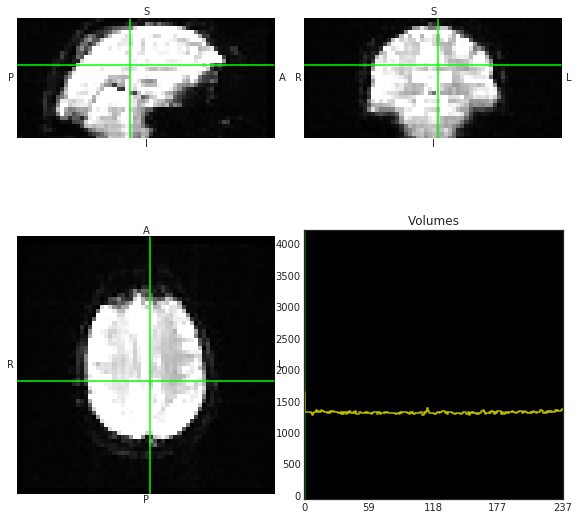

In [24]:
epi.orthoview()

Remembering that the data object is just a numpy array, we can easily take the mean over time:

In [25]:
mean_data = epi.get_data().mean(axis=3)
mean_data.shape

(64, 64, 30)

<OrthoSlicer3D: (64, 64, 30)>

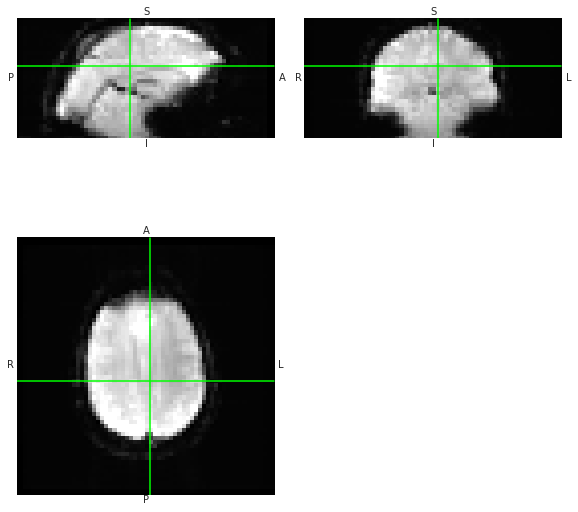

In [26]:
mean_epi = nib.Nifti1Image(mean_data, affine=epi.affine, header=epi.header)
mean_epi.orthoview()

Looks how we'd expect. Let's save it!

In [27]:
mean_epi.to_filename(os.path.join(out_dir, 'mean_epi.nii.gz'))

## Review

We've learned about nibabel, a low-level Python library for reading and writing common neuroimaging formats.

Volumetric image formats are organized in a data-affine-header structure; the data is exposed as an n-dimensional numpy array, and the orientation of the data array is encoded in both the affine and the header.

Images can be written using the `.to_filename()` method, and the on-disk data type can be adjusted with the `header.set_data_dtype()` method.

Finally, we learned about `.orthoview()` and the `nib-ls` command-line program, for rapid inspection of data files.

# Nilearn

Nilearn is a library which makes visualizing neuroimages and exposing them to machine learning algorithms straightforward.

It also simplifies a number of common tasks with neuroimages. For example, we can recreate the mean EPI image we just made in one line:

In [28]:
img = nl.image.mean_img('/data/ds000114/sub-01/ses-test/func/sub-01_ses-test_task-linebisection_bold.nii.gz')
print(img)

<class 'nibabel.nifti1.Nifti1Image'>
data shape (64, 64, 30)
affine: 
[[ -3.99471426e+00  -2.04233140e-01   2.29353290e-02   1.30641693e+02]
 [ -2.05448717e-01   3.98260689e+00  -3.10890853e-01  -9.74732285e+01]
 [  6.95819734e-03   3.11659902e-01   3.98780894e+00  -8.06465759e+01]
 [  0.00000000e+00   0.00000000e+00   0.00000000e+00   1.00000000e+00]]
metadata:
<class 'nibabel.nifti1.Nifti1Header'> object, endian='<'
sizeof_hdr      : 348
data_type       : b''
db_name         : b''
extents         : 0
session_error   : 0
regular         : b''
dim_info        : 0
dim             : [ 3 64 64 30  1  1  1  1]
intent_p1       : 0.0
intent_p2       : 0.0
intent_p3       : 0.0
intent_code     : none
datatype        : float64
bitpix          : 64
slice_start     : 0
pixdim          : [-1.          4.          4.          3.99997497  1.          1.          1.
  1.        ]
vox_offset      : 0.0
scl_slope       : nan
scl_inter       : nan
slice_end       : 0
slice_code      : unknown
xyzt_unit

Nilearn images are just nibabel images! But notice that we didn't have to copy the affine or header. Nilearn does its best to keep your data and metadata together.

Let's verify that both methods produced the same image.

In [29]:
np.array_equal(mean_epi.get_data(), img.get_data())

True

In [30]:
np.array_equal(mean_epi.affine, img.affine)

True

## Plotting images

Nilearn has a variety of plotting facilities. `plot_epi` shows functional images in a high-contrast color scheme.

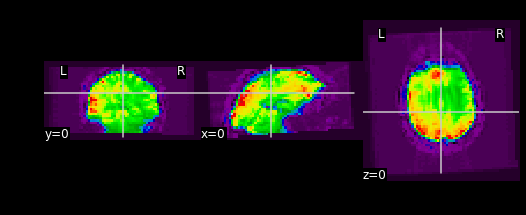

In [31]:
nl.plotting.plot_epi(mean_epi, cut_coords=(0, 0, 0))

We can also plot anatomical images. Let's show the FreeSurfer `aseg` segmentation over the T1 image we loaded earlier:

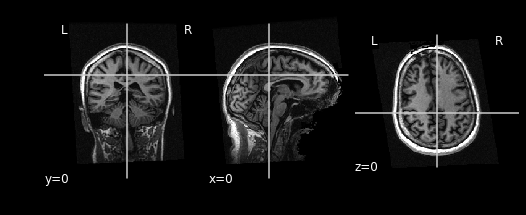

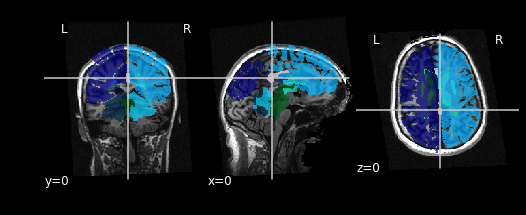

In [32]:
nl.plotting.plot_anat(t1, dim=-1, cut_coords=(0, 0, 0))
nl.plotting.plot_roi('/data/ds000114/derivatives/freesurfer/sub-01/mri/aseg.mgz', t1,
                     dim=-1, cut_coords=(0, 0, 0))

But the overlay above looks misaligned. That's because this dataset uses a derived T1 image as input to freesurfer.

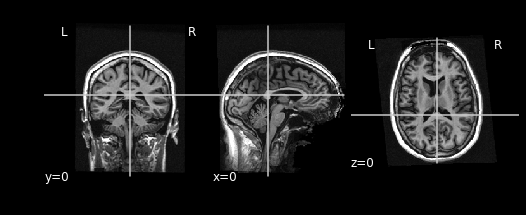

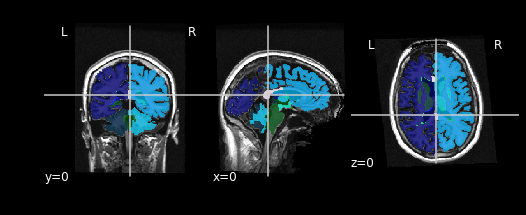

In [34]:
t1 = nib.load('/data/ds000114/derivatives/fmriprep/sub-01/anat/sub-01_t1w_preproc.nii.gz')
nl.plotting.plot_anat(t1, dim=-1, cut_coords=(0, 0, 0))
nl.plotting.plot_roi('/data/ds000114/derivatives/freesurfer/sub-01/mri/aseg.mgz', t1,
                     dim=-1, cut_coords=(0, 0, 0))

Notice that nilearn will accept an image or a filename equally. Also recall that `t1` was a NIfTI-1 image, while `aseg` is in a FreeSurfer `.mgz` file. Nilearn takes advantage of the common interface (data-affine-header) that nibabel provides for these different formats, and makes correctly aligned overlays.

This means we can use nilearn to verify alignment, for example when testing a new algorithm.

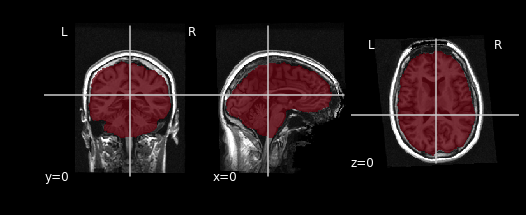

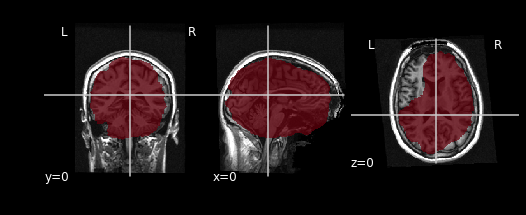

In [35]:
def new_algorithm(image):
    # Just mess up the affine
    bad_affine = image.affine.copy()
    bad_affine[:, :2] = mask.affine[:, 1::-1]
    return image.__class__(image.get_data(), bad_affine, mask.header)

mask = nl.image.math_img("img > 0", img='/data/ds000114/derivatives/freesurfer/sub-01/mri/brainmask.auto.mgz')

nl.plotting.plot_roi(mask, t1, dim=-1, cut_coords=(0, 0, 0), cmap='Reds_r')
nl.plotting.plot_roi(new_algorithm(mask), t1, dim=-1, cut_coords=(0, 0, 0), cmap='Reds_r')

## Plotting surfaces

Nilearn has recently added surface plotting to its repertoire. Let's examine the gray/white boundary and pial surfaces.

In [36]:
white = '/data/ds000114/derivatives/freesurfer/sub-01/surf/lh.white'
pial = '/data/ds000114/derivatives/freesurfer/sub-01/surf/lh.pial'
sulc = '/data/ds000114/derivatives/freesurfer/sub-01/surf/lh.sulc'

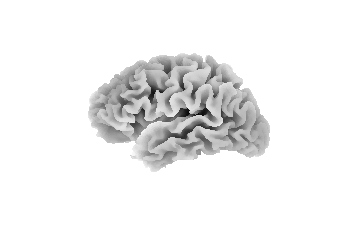

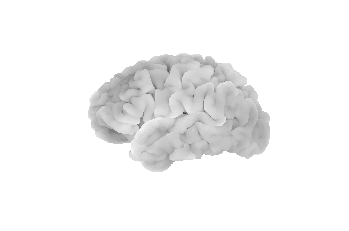

In [37]:
_ = nl.plotting.plot_surf(white, bg_map=sulc)
_ = nl.plotting.plot_surf(pial, bg_map=sulc)

A common step in surface pipelines is to create a surface halfway between the white and pial surface (often called the "midthickness" or "graymid" surface). The fastest, easiest, possibly wrong (but in practice fine) way to get this surface is to take the mean of the coordinates of the corresponding vertices on the white and pial surface. We can do this straightforwardly in nibabel.

In [38]:
wcoords, wfaces, wmeta = nib.freesurfer.read_geometry(white, read_metadata=True)
pcoords, pfaces = nib.freesurfer.read_geometry(white, read_metadata=False)

# Make sure these surfaces actually do correspond
assert np.array_equal(wfaces, pfaces)

(wcoords, wfaces, wmeta)

(array([[ -4.46079874, -87.27874756,  -4.03093672],
        [ -4.81690741, -87.32863617,  -4.25572157],
        [ -3.69867802, -87.19690704,  -4.92648315],
        ..., 
        [-17.97581482,  64.82131195,  -2.18233109],
        [-15.90557671,  65.3068924 ,  -1.68188572],
        [-18.01537704,  65.78809357,  -2.01027656]]),
 array([[     0,      1,      3],
        [     4,      3,      1],
        [     0,     62,     63],
        ..., 
        [102477, 102687, 102677],
        [102676, 103021, 102862],
        [102687, 102688, 102677]], dtype=int32),
 OrderedDict([('head', array([ 2,  0, 20], dtype=int32)),
              ('valid', '1  # volume info valid'),
              ('filename', '../mri/filled-pretess255.mgz'),
              ('volume', array([256, 256, 256])),
              ('voxelsize', array([ 1.,  1.,  1.])),
              ('xras',
               array([ -1.00000024e+00,  -5.03496267e-09,   9.31322575e-10])),
              ('yras', array([ 0.        ,  0.        , -1.000000

Notice that this is not an image object, just a tuple of coordinates, faces, and an optional metadata dictionary. And it's an example of a file nibabel doesn't handle with `nibabel.load()`.

Coordinates are the (x, y, z) coordinates of each vertex; faces are a triangle composed of three vertices, and the metadata describes the provenance and alignment.

In [39]:
gcoords = (wcoords + pcoords) / 2
# nilearn can be pretty picky about names, so fool it into reading this as a surface file
graymid = os.path.join(out_dir, 'lh.white')
nib.freesurfer.write_geometry(graymid, gcoords, wfaces, volume_info=wmeta)

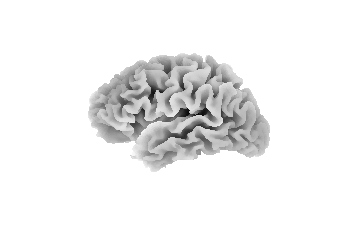

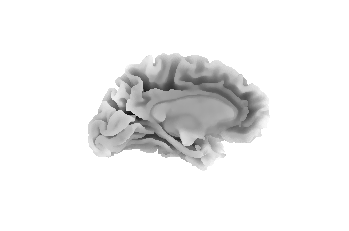

In [40]:
_ = nl.plotting.plot_surf(graymid, bg_map=sulc, view='lateral')
_ = nl.plotting.plot_surf(graymid, bg_map=sulc, view='medial')

Looks reasonable. Let's overlay it with the `aparc` parcellation. Nilearn doesn't handle these well yet, so again, we'll load with nibabel.

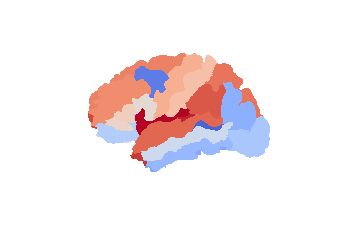

In [41]:
aparc = nib.freesurfer.read_annot('/data/ds000114/derivatives/freesurfer/sub-01/label/lh.aparc.annot')

_ = nl.plotting.plot_surf_roi(os.path.join(out_dir, 'lh.white'), aparc[0], bg_map=sulc, view='lateral')

### Review

We've explored the visualization capabilities of nilearn, which include the ability to plot BOLD images, ROIs and masks overlaid on anatomical images and surfaces. Additionally, we've used nilearn's image manipulation utilities (`mean_img`, and `math_img`) to quickly create new, valid images, and considered the dangers of destroying your affine matrix. Finally, we created our own surface using nibabel's FreeSurfer utilities.

# Conclusions

In this tutorial, we've explored loading, saving and visualizing neuroimages, as well as how nibabel and nilearn can make some more sophisticated manipulations easy. At this point, you should be able to inspect and plot most images you encounter, as well as make modifications while preserving the alignment. If we've made it through the final section, you've also seen the basic workflow for performing a wide range of statistical analyses on BOLD time series in nilearn.